# Andrew Ng's Machine Learning MOOC: Week 9: Anomaly Detection and Recommender Systems


# Programming Exercise 8

## 0. Introduction
This notebook contains my solutions to the programming exercise for week 9 of Andrew Ng's famous Machine Learning MOOC on Coursera (https://www.coursera.org/learn/machine-learning).

As in week 8 / programming exercise 8, this week's exercise comes in two parts (to match the two topics covered in this week's lectures) - which I've separated into two separate notebooks:
- In the first part, we implemented a Guassian anomaly detection algorithm and applied it to detect failing servers on a network.
- In **this**, the second part, we will use collaborative filtering to build a recommender system for films.

Now, the course requires submission of programming exercises in either the MATLAB or OCTAVE programming language.
However since:
- I already code in Python for various web development and data science projects, and
- Python is the pre-eminent language currently used in data science and machine learning (and MATLAB and OCTAVE don't seem to be used anywhere near as much)
I decided it would be more valuable to me to use Python to complete the programming exercises.

I was therefore very pleased to find the following source, which has kindly written a set of python scripts to allow one to create Python implementations of the programming exercises for the course, and still submit them for scoring by the MOOC: https://github.com/dibgerge/ml-coursera-python-assignments

Thanks very much `dibgerge!`

In addition to the course's own lecture materials, I also used a number of other sources to help me solve the programming exercises. These include:

#### Other courses I've completed:
- Harvard's *Using Python for Research* on edX: https://www.edx.org/course/using-python-for-research
- UC San Diego's *Python for Data Science*, also on edX: https://www.edx.org/course/python-for-data-science-2
- MIT's *Introduction to Computational Thinking and Data Science I and II*, also on edX: https://www.edx.org/course/introduction-to-computational-thinking-and-data-4
- Imperial College London's *Mathematics for Machine Learning I-III* on Coursera: https://www.coursera.org/specializations/mathematics-machine-learning
- Goldsmith's / University of London's *Foundations of Data Science: K-means Clustering in Python* on Coursera: https://www.coursera.org/learn/data-science-k-means-clustering-python

#### Books:
- Python Machine Learning by Sebastian Raschka and Vahid Mirjalili: https://sebastianraschka.com/books.html

#### Blogs and websites
- I found [this blog](https://www.johnwittenauer.net/machine-learning-exercises-in-python-part-8/) to be very useful reference throughout this course:
- I want to give a huge shout out to [this](https://towardsdatascience.com/combo-charts-with-seaborn-and-python-2bc911a08950) blog post for showing me how to create what `excel` refers to as a "combo-chart" in `matplotlib` / `seaborn`!
- Jake Vanderplas's ["Python Data Science Handbook"](https://jakevdp.github.io/PythonDataScienceHandbook/index.html) is an invaluable resource - I find it especially useful for details of working with `numpy`, `pandas`, and `matplotlib`

And of course, there's always StackOverflow!

One thing that struck me, looking at all of these different resources, is how many different ways there are to implement basically the same code in python, even using numpy and pandas dataframes! And that's before we think about object-oriented implementations, or using libraries such as `scikitlearn`.

OK, now that the introduction is complete, let's get started with some imports. You can find instructions on how to install required libraries in the README file in `dibgerge`'s github repository.

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Data-wrangling library for python
import pandas as pd

# Plotting libraries
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Optimization module in scipy
from scipy import optimize

# Stats module in scipy
from scipy import stats

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## 1 Recommender Systems

In this part of the exercise, we will implement the collaborative filtering learning algorithm and apply it to a dataset of film ratings ([MovieLens 100k Dataset](https://grouplens.org/datasets/movielens/) from GroupLens Research). This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u = 943$ users, and $n_m = 1682$ films. 

Spcifically, we will implement the function `cofiCostFunc()`, which computes the collaborative filtering objective function and gradient. After implementing the cost function and gradient, we will use `scipy.optimize.minimize` to learn the parameters for collaborative filtering.

### 1.1 Movie ratings dataset

First, let's load the data!

The matrix `Y` (a `num_films` $\times$ `num_users` matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5) that users have given to different films. Note that not users will not have rated all films, so there will be plenty of `null` values in this matrix.

The matrix `R` is an binary-valued indicator matrix, where $R(i, j) = 1$ if user $j$ gave a rating to film $i$, and $R(i, j) = 0$ otherwise. The objective of collaborative filtering is to predict film ratings for the films that users have not yet rated, that is, the entries with $R(i, j) = 0$. This will allow us to recommend to the user those films with the highest predicted ratings for them, based on the films that they *have* reviewed.

In [2]:
# Load data
data = loadmat(os.path.join('Data', 'ex8_movies.mat'))
Y, R = data['Y'], data['R']

Let's take a look at the data:

In [3]:
Y.shape

(1682, 943)

In [4]:
Y

array([[5, 4, 0, ..., 5, 0, 0],
       [3, 0, 0, ..., 0, 0, 5],
       [4, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [5]:
R.shape

(1682, 943)

In [6]:
R

array([[1, 1, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Note that:
- there are plenty of 0-values (null values) in both Y and R indicating that plenty of films have not been rated by plenty of users
- the data don't tell us which film is which - there is no data on e.g. *film titles*. This is case where it would have been beneficial to load the data into some dataframes (or an API to an SQL database), so we could match the ratings data with the name of the film. After all, our objective is to present users with films we think they might like - and we're not really going to want to say things like "*Hey - based on your ratings, we think you're going to love film 0356!*". Anyway...

Anyway, from the data we can calculate stats such as the mean rating for a film:

In [7]:
# Calculate mean rating for film in position 0 of our data
print("Average rating for first film: {:.0f}%".format((np.mean(Y[0, R[0, :] == 1])/5)*100))

Average rating for first film: 78%


We can also visualize which films have been rated by which users - or at least the density of film ratings - by plotting it with `matplotlib`'s `imshow()` method:

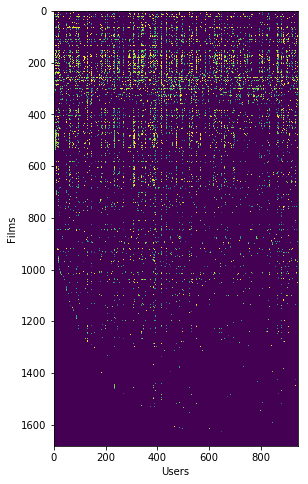

In [8]:
# Plot the ratings matrix with imshow
plt.figure(figsize=(8, 8))
plt.imshow(Y)
plt.ylabel('Films')
plt.xlabel('Users')
plt.grid(False)

We can see that the "first" 600-or-so films have been rated by many more users than the other films.

In fact, let's have have a look at the distribution function of how many ratings each film has been given. We'll use a `pandas dataframe` to manipulate our data:

In [9]:
# open R data in a pandas dataframe
df = pd.DataFrame(R)
# create new column summming the number of ratings over all the columns
df['num_ratings'] = df.sum(axis = 1)
# sort the dataframe in descending order of num_ratings
df = df.sort_values(by=['num_ratings'], ascending=False)
# add a cumulative frequency column
df['cumulative_frequency'] = df['num_ratings'].cumsum()
# add a cumulative % of total ratings column
df['cumulative_percent_total_ratings'] = df['cumulative_frequency']/df['cumulative_frequency'].iloc[1681]
df.head(50)

,0,1,2,3,4,5,6,7,8,9,...,936,937,938,939,940,941,942,num_ratings,cumulative_frequency,cumulative_percent_total_ratings
49,1,1,0,1,1,1,1,1,1,1,...,1,1,0,1,0,1,1,583,583,0.00583
257,1,1,1,1,0,1,1,1,0,0,...,1,1,1,1,1,1,0,509,1092,0.01092
99,1,1,0,0,1,1,1,0,0,1,...,1,1,0,1,0,0,1,508,1600,0.01600
180,1,0,1,0,1,0,1,1,0,0,...,0,1,0,1,1,0,1,507,2107,0.02107
293,0,1,1,1,0,1,1,1,1,1,...,1,0,0,1,1,0,0,485,2592,0.02592
285,0,1,0,0,0,1,1,0,1,1,...,1,1,0,1,0,0,0,481,3073,0.03073
287,0,1,1,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,478,3551,0.03551
0,1,1,0,0,1,1,0,0,0,1,...,0,1,0,0,1,0,0,452,4003,0.04003
299,0,1,1,1,0,0,1,0,0,0,...,1,1,0,1,1,1,0,431,4434,0.04434
120,1,0,0,0,1,0,1,0,0,0,...,0,1,1,0,0,0,1,429,4863,0.04863


Now, what I'd like to do is to create a chart showing the number of ratings (as a bar) for each film with a line chart of cumulative frequency, expressed as a % of the total number of ratings.

This is pretty easy to do in *excel*. First we'd export the data to excel:

df.to_excel("output.xlsx") 

And then we could pretty quickly pull together a chart, looking something like this:

<img src="figures/example_chart.png">

However, in matplotlib, or seaborn it seems *very very difficult* to do this! I've *a number of hours* looking around on the internet trying to find out how to do this. I tried using density functions, and histograms, and bar charts - none of them give me what I want. Which is quite annoying as this is a type of chart that I create *all the time*.

There must be *some* way to do it - and one day I'll find out what!

In the meantime, we can at least interrogate the data through some simple line charts [yes, these are ugly and aren't at all what I really want - and I don't understand why I've got the additional, empty charts at the top...presumably some interaction I haven't really thought through between the `ax` object and the `df.plot` object...anyway, let's move on.

[<matplotlib.text.Text at 0x130c17978>, <matplotlib.text.Text at 0x130bf8cc0>]

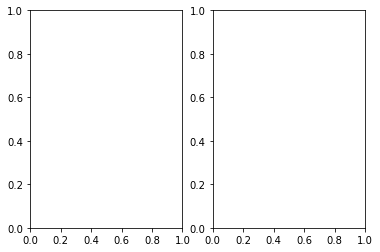

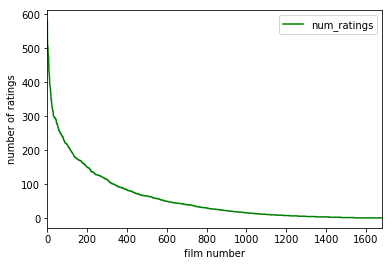

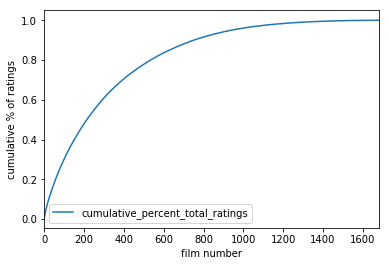

In [10]:
fig, ax = plt.subplots(1,2)

ax[0] = df.plot(x=(pd.Series(list(range(len(df))))), y='num_ratings', color = 'green')
ax[0].set(xlabel = 'film number', ylabel = 'number of ratings')

ax[1] = df.plot(x=(pd.Series(list(range(len(df))))), y='cumulative_percent_total_ratings')
ax[1].set(xlabel = 'film number', ylabel = 'cumulative % of ratings')

All I wanted to do was to look at the cumulative distribution of ratings, and note that 80% of the ratings have been made for ~550-or-so films (out of 1,683).

What a palaver!

Anyway, after that afternoon-long detour into matplotlib and seaborn, let's move on.

#### Afternote - further playing with `pandas`, `matplotlib`, and `seaborn`

It occurred to me that maybe the problems I've been having might be due to the fact that I lack a specific `Series` (i.e. a column in my `DataFrame`) to represent the number of films - to which I can then refer when I'm setting up my `ax` object. So maybe I can try adding one. To be clear, obviously there's an *index* - which is the ID of the film in the original data set. But what I need is a column, with values from 1-1682, in order. Let's add that:

In [33]:
# add column of numbers - same as number of films
df['film_number'] = np.arange(len(df))
# convert from 0-index to 1-ind
df['film_number'] += 1

In [41]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,937,938,939,940,941,942,num_ratings,cumulative_frequency,cumulative_percent_total_ratings,film_number
49,1,1,0,1,1,1,1,1,1,1,...,1,0,1,0,1,1,583,583,0.00583,1
257,1,1,1,1,0,1,1,1,0,0,...,1,1,1,1,1,0,509,1092,0.01092,2
99,1,1,0,0,1,1,1,0,0,1,...,1,0,1,0,0,1,508,1600,0.01600,3
180,1,0,1,0,1,0,1,1,0,0,...,1,0,1,1,0,1,507,2107,0.02107,4
293,0,1,1,1,0,1,1,1,1,1,...,0,0,1,1,0,0,485,2592,0.02592,5


Now let's see if we can create the chart we want:

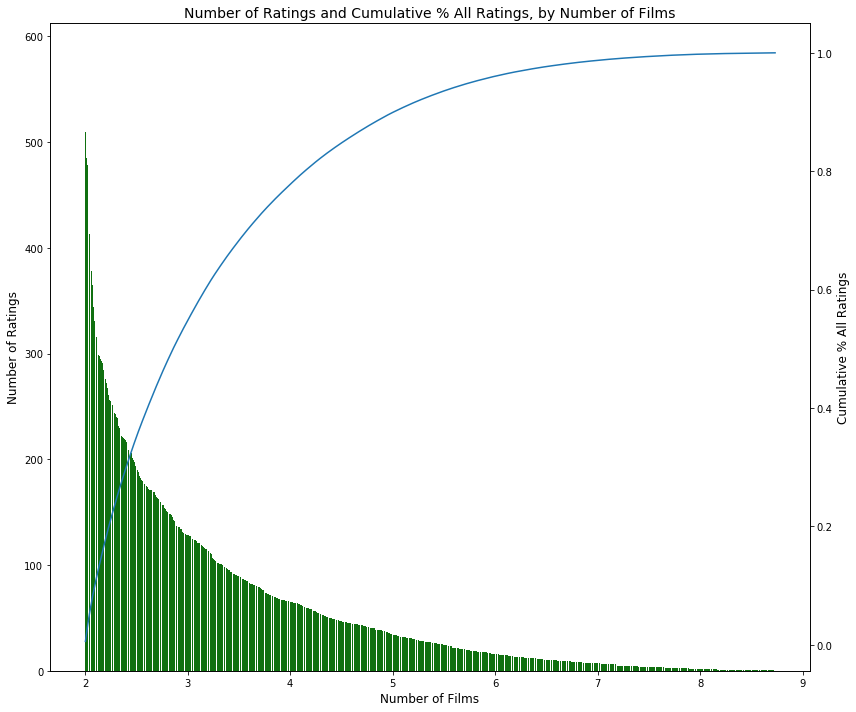

In [64]:
# import tick mark formatting modules
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

# initialize figure, ax objects
fig, ax1 = plt.subplots(figsize=(12,10))

# set parameters for presentation of x-axis
# major ticks at 200, no minor ticks, no labels

# ax1.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='minor',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off

# create first part of chart - bar chart showing number of ratings per film
color = 'green'
ax1.set_title('Number of Ratings and Cumulative % All Ratings, by Number of Films', fontsize=14)
ax1 = sns.barplot(x='film_number', y='num_ratings', data = df, color=color)
ax1.xaxis.set_major_locator(plt.MaxNLocator(8))
ax1.xaxis.set_minor_locator(plt.NullLocator())
ax1.set_xlabel('Number of Films', fontsize=12)
ax1.set_ylabel('Number of Ratings', fontsize=12)
ax1.tick_params(axis='y')

# create second part of chart - line chart showing cumulative % of all ratings
# 'twin' x-axis, so both sets of data plotted on same x-axis, but separate y-axes
ax2 = ax1.twinx()
color = 'blue'
ax2 = sns.lineplot(x='film_number', y='cumulative_percent_total_ratings', data = df, sort=False)
ax1.xaxis.set_major_locator(plt.MaxNLocator(8))
ax1.xaxis.set_minor_locator(plt.NullLocator())
ax2.set_ylabel('Cumulative % All Ratings', fontsize=12)
ax2.tick_params(axis='y')

# adjust layout
fig.tight_layout()

Once again, I want to give a huge shout out to [this](https://towardsdatascience.com/combo-charts-with-seaborn-and-python-2bc911a08950) blog post for showing me how to create what `excel` refers to as a "combo-chart" in `matplotlib` / `seaborn`!

### 1.2 Collaborative filtering learning algorithm

Now, we will start implementing the collaborative filtering learning algorithm.

The collaborative filtering algorithm in the setting of film recommendations considers a set of n-dimensional parameter vectors $x^{(1)}, \dots, x^{(n_m)}$ and $\theta^{(1)} , \dots, \theta^{(n_u)}$, where the model predicts the rating for film $i$ by user $j$ as $y^{(i,j)} = \left( \theta^{(j)} \right)^T x^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some films, you wish to learn the parameter vectors $x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)}$ that produce the best fit (minimizes the squared error).

This we will also be working with the matrices, `X` and `Theta`:

$$ \text{X} = 
\begin{bmatrix}
- \left(x^{(1)}\right)^T - \\
- \left(x^{(2)}\right)^T - \\
\vdots \\
- \left(x^{(n_m)}\right)^T - \\
\end{bmatrix}, \quad
\text{Theta} = 
\begin{bmatrix}
- \left(\theta^{(1)}\right)^T - \\
- \left(\theta^{(2)}\right)^T - \\
\vdots \\
- \left(\theta^{(n_u)}\right)^T - \\
\end{bmatrix}.
$$

The $i^{th}$ row of `X` corresponds to the feature vector $x^{(i)}$ for the $i^{th}$ film, and the $j^{th}$ row of `Theta` corresponds to one parameter vector $\theta^{(j)}$, for the $j^{th}$ user. Both $x^{(i)}$ and $\theta^{(j)}$ are n-dimensional vectors.

For the purposes of this exercise, we will use $n = 100$, and therefore, $x^{(i)} \in \mathbb{R}^{100}$ and $\theta^{(j)} \in \mathbb{R}^{100}$. Correspondingly, `X` is a $n_m \times 100$ matrix and `Theta` is a $n_u \times 100$ matrix.

Our task is to complete the code in `cofiCostFunc()` to compute the cost function and gradient for collaborative filtering. Note that the parameters to the function (i.e., the values that you are trying to learn) are `X` and `Theta`. In order to use an off-the-shelf minimizer such as `scipy`'s `minimize` function, the cost function has been set up to unroll the parameters into a single vector called `params`. We  previously used the same vector unrolling method in the neural networks programming exercise.

We will start by implementing the cost function, seprating out our discussion of regularization. Then we'll implement the gradient, again separating out the regularization step.

Our calculation of both the cost function and the gradient, with regularization, will all get built into our `cofiCostFunc()` function.

#### 1.2.1 Collaborative filtering cost function

The collaborative filtering cost function (without regularization) is given by

$$
J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots,\theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right)^2
$$

The first part of our task is to modify the function `cofiCostFunc` to return this cost in the variable `J`. Note that our function should be accumulating the cost for user $j$ and movie $i$ only if `R[i,j] = 1`.

<div class="alert alert-block alert-warning">
**Implementation Note**: We are definitely going to want to use a vectorized implementation to compute $J$,  and the gradients, since it will later by called many times by `scipy`'s optimization package. It turns out this is not that difficult, and we can do it with a lot fewer lines of code than if we were using `for-loop`s to iterate over every film, user, and their ratings!
</div>

#### 1.2.2 Regularized cost function

Now we're going to add regularization to the calculation of the cost, $J$.

The cost function for collaborative filtering with regularization is given by:

$$ J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right)^2 + \left( \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^{n} \left( \theta_k^{(j)} \right)^2  \right) + \left( \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n \left(x_k^{(i)} \right)^2 \right) $$

Again, the vectorized implementation is pretty simple - we simply add the two new $\lambda$ terms, which are calculated as simple multiplications of matrices.

#### 1.2.3 Collaborative filtering gradient

Now we move on to implement the gradient (*without* regularization). Again, we need to complete the code in `cofiCostFunc()` to return the variables `X_grad` and `Theta_grad`. Note that `X_grad` should be a matrix of the same size as `X` and similarly, `Theta_grad` is a matrix of the same size as `Theta`. The gradients of the cost function is given by:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} $$

$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(j)} $$

Note that the function returns the gradient for both sets of variables by unrolling them into a single vector.

#### 1.2.4 Regularized gradient

Finally, we will add regularization to the gradients - where the gradients for the regularized cost function is given by:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} + \lambda x_k^{(i)} $$

$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(j)} + \lambda \theta_k^{(j)} $$

Again, this is simple to do in a vectorized implementation - all we have to do is:
- add $\lambda x^{(i)}$ to the gradient term for X (`X_grad`) that we calculated earlier; and
- add $\lambda \theta^{(j)}$ to the gradient term for Theta (`Theta_grad`).


The code for all four of these parts is in the cell below:

In [14]:
def cofiCostFunc(params, Y, R, num_users, num_movies,
                      num_features, lambda_=0.0):
    """
    Collaborative filtering cost function.
    
    Parameters
    ----------
    params : array_like
        The parameters which will be optimized. This is a one
        dimensional vector of shape (num_movies x num_users, 1). It is the 
        concatenation of the feature vectors X and parameters Theta.
    
    Y : array_like
        A matrix of shape (num_movies x num_users) of user ratings of movies.
    
    R : array_like
        A (num_movies x num_users) matrix, where R[i, j] = 1 if the 
        i-th movie was rated by the j-th user.
    
    num_users : int
        Total number of users.
    
    num_movies : int
        Total number of movies.
    
    num_features : int
        Number of features to learn.
    
    lambda_ : float, optional
        The regularization coefficient.
    
    Returns
    -------
    J : float
        The value of the cost function at the given params.
    
    grad : array_like
        The gradient vector of the cost function at the given params.
        grad has a shape (num_movies x num_users, 1)
    
    Notes
    -----
    - The input params will be unraveled into the two matrices:
        X : (num_movies  x num_features) matrix of movie features
        Theta : (num_users  x num_features) matrix of user features

    - We need to set the following variables correctly:

        X_grad : (num_movies x num_features) matrix, containing the 
                 partial derivatives w.r.t. to each element of X
        Theta_grad : (num_users x num_features) matrix, containing the 
                     partial derivatives w.r.t. to each element of Theta

    - The returned gradient will be the concatenation of the raveled 
      gradients X_grad and Theta_grad.
    """
    # Unfold the U and W matrices from params
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)

    # Initialize [the constituent parts of] our outputs
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    
    
    # Calculate cost (unregularized)
    # ...calculate error
    error = np.dot(X, Theta.T) - Y
    # ...calculate this only for R = 1
    error = np.multiply(error, R)
    # ...square the errors
    squared_error = error**2
    # ...sum over the error matrix and divide by 2
    J = (np.sum(squared_error))/2
    
    # Add regularization to cost
    # ...first regularization term
    J += (lambda_/2) * np.sum(X**2)
    # ...second regularization term
    J += (lambda_/2) * np.sum(Theta**2)

    
    # Calculate gradients (unregularized)
    X_grad = np.dot(error, Theta)
    Theta_grad = np.dot(error.T, X)
    
    # Add regularization to gradients
    X_grad += np.multiply(lambda_, X)
    Theta_grad += np.multiply(lambda_, Theta)
    
    
    # 'Roll-up' X_grad and Theta_grad into a single vector
    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    return J, grad

### 1.3 Test cases

The test case below, provided by the course (and coded up for us by `dibgerge`), tests our implementation of the cost function *without regularization* (feel free to #-out the regularization code if you want to check it):

In [15]:
#  Load pre-trained weights (X, Theta, num_users, num_movies, num_features)
data = loadmat(os.path.join('Data', 'ex8_movieParams.mat'))
X, Theta, num_users, num_movies, num_features = data['X'],\
        data['Theta'], data['num_users'], data['num_movies'], data['num_features']

#  Reduce the data set size so that this runs faster
num_users = 4
num_movies = 5
num_features = 3

X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, 0:num_users]
R = R[:num_movies, 0:num_users]

#  Evaluate cost function
J, _ = cofiCostFunc(np.concatenate([X.ravel(), Theta.ravel()]),
                    Y, R, num_users, num_movies, num_features)
           
print('Cost at loaded parameters:  %.2f \n(this value should be about 22.22)' % J)

Cost at loaded parameters:  22.22 
(this value should be about 22.22)


And here we have a test case provided for us for the *regularized* cost function. We should get a cost of approximately *31.34*:

In [16]:
#  Evaluate cost function
J, _ = cofiCostFunc(np.concatenate([X.ravel(), Theta.ravel()]),
                    Y, R, num_users, num_movies, num_features, 1.5)
           
print('Cost at loaded parameters (lambda = 1.5): %.2f' % J)
print('              (this value should be about 31.34)')

Cost at loaded parameters (lambda = 1.5): 31.34
              (this value should be about 31.34)


We can also test how our code to calculate the gradients is working. The next cell runs a gradient check (provided for us in `utils.checkCostFunction`) to numerically check the implementation of gradients (this is similar to the numerical check that we used in the neural networks exercise). If our implementation is correct, we should find that the analytical and numerical gradients match up closely.

In [17]:
#  Check gradients by running checkcostFunction
utils.checkCostFunction(cofiCostFunc)

[[ 3.89858239  3.89858239]
 [-5.44356862 -5.44356862]
 [ 7.56038184  7.56038184]
 [ 0.07602367  0.07602367]
 [-0.03208509 -0.03208509]
 [ 0.10428006  0.10428006]
 [ 3.7486946   3.7486946 ]
 [ 1.51219263  1.51219263]
 [ 1.65323525  1.65323525]
 [ 1.42693783  1.42693783]
 [-2.32141704 -2.32141704]
 [ 2.3591935   2.3591935 ]
 [-1.90076483 -1.90076483]
 [ 2.05291766  2.05291766]
 [ 0.99123211  0.99123211]
 [-3.33675549 -3.33675549]
 [ 2.48263767  2.48263767]
 [-5.87411371 -5.87411371]
 [-0.21063996 -0.21063996]
 [ 3.2876185   3.2876185 ]
 [-7.53430293 -7.53430293]
 [ 0.4995329   0.4995329 ]
 [ 1.68889247  1.68889247]
 [-1.16293758 -1.16293758]
 [ 1.41172861  1.41172861]
 [ 2.99212474  2.99212474]
 [-3.77086444 -3.77086444]]

The above two columns you get should be very similar.(Left-Your Numerical Gradient, Right-Analytical Gradient)
If your cost function implementation is correct, then the relative difference will be small (less than 1e-9).

Relative Difference: 2.45681e-12


And below is a second test case, again kindly provided by the course / `dibgerge`, against which we can test our regularized implementation:

In [18]:
#  Check gradients by running checkCostFunction
utils.checkCostFunction(cofiCostFunc, 1.5)

[[-10.85982935 -10.85982935]
 [ 12.46487389  12.46487389]
 [  2.73867536   2.73867536]
 [  2.06825624   2.06825624]
 [  0.45284492   0.45284492]
 [ -0.75733492  -0.75733492]
 [ -1.53193978  -1.53193978]
 [ -4.39355865  -4.39355865]
 [  3.13281578   3.13281578]
 [ -1.0652237   -1.0652237 ]
 [  1.95238919   1.95238919]
 [  2.10912963   2.10912963]
 [  7.39407398   7.39407398]
 [-22.69254956 -22.69254956]
 [ -6.07032807  -6.07032807]
 [ -0.03905304  -0.03905304]
 [  4.72382791   4.72382791]
 [ -2.49387899  -2.49387899]
 [ -0.86203319  -0.86203319]
 [ -0.75618797  -0.75618797]
 [  1.44334824   1.44334824]
 [ -3.46887082  -3.46887082]
 [ -1.18014822  -1.18014822]
 [  0.60272676   0.60272676]
 [  1.26234026   1.26234026]
 [ -3.95906924  -3.95906924]
 [  0.91017638   0.91017638]]

The above two columns you get should be very similar.(Left-Your Numerical Gradient, Right-Analytical Gradient)
If your cost function implementation is correct, then the relative difference will be small (less than 1

### 1.4 Learning movie recommendations 

Great! We can now start training our algorithm to make movie recommendations for yourself. In the next cell, we can enter our own movie preferences, so that later when the algorithm runs, we can get our own movie recommendations! The list of all movies and their number in the dataset can be found listed in the file `Data/movie_idx.txt`. So let's start by adding some of our own ratings (from 1-5) for a selection of films:

In [19]:
#  Before we will train the collaborative filtering model, we will first
#  add ratings that correspond to a new user that we just observed. This
#  part of the code will also allow us to put in your own ratings for the
#  movies in our dataset!
movieList = utils.loadMovieList()
n_m = len(movieList)

#  Initialize my ratings
my_ratings = np.zeros(n_m)

# Check the file movie_idx.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
my_ratings[0] = 4
# Note that the index here is ID-1, since we start index from 0.

# Similarly, if we did not enjoy Silence of the Lambs (1991) - which has ID 98 - set
my_ratings[97] = 1

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[3] = 5
my_ratings[11]= 5
my_ratings[16] = 4
my_ratings[29] = 3
my_ratings[41] = 4
my_ratings[69] = 5
my_ratings[70] = 4
my_ratings[89] = 4
my_ratings[99] = 5
my_ratings[170] = 5
my_ratings[239] = 2
my_ratings[270] = 5
my_ratings[651] = 3
my_ratings[1088] = 3


print('New user ratings:')
print('-----------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d stars: %s' % (my_ratings[i], movieList[i]))

New user ratings:
-----------------
Rated 4 stars: Toy Story (1995)
Rated 5 stars: Get Shorty (1995)
Rated 5 stars: Usual Suspects, The (1995)
Rated 4 stars: From Dusk Till Dawn (1996)
Rated 3 stars: Belle de jour (1967)
Rated 4 stars: Clerks (1994)
Rated 5 stars: Four Weddings and a Funeral (1994)
Rated 4 stars: Lion King, The (1994)
Rated 4 stars: So I Married an Axe Murderer (1993)
Rated 1 stars: Silence of the Lambs, The (1991)
Rated 5 stars: Fargo (1996)
Rated 5 stars: Delicatessen (1991)
Rated 2 stars: Beavis and Butt-head Do America (1996)
Rated 5 stars: Starship Troopers (1997)
Rated 3 stars: Rosencrantz and Guildenstern Are Dead (1990)
Rated 3 stars: Speed 2: Cruise Control (1997)


#### 1.4.1 Recommendations

Now we've added our ratings to the dataset, we can train the collaborative filtering model. This will learn the
parameters X and Theta. To predict the rating of film *i* for user *j*, we need to compute ($\theta^j)^T X^i$.

We can compute the predicted ratings of *all users* for *all films* as $\Theta^TX$.

The code below computes the ratings for all the films and users and displays the films that it recommends according to ratings that were entered earlier in the script. Note that each "run" is likely to give a different set of the predictions due to different random initializations.

In [20]:
#  Here we train the collaborative filtering model on a movie rating 
#  dataset of 1682 movies and 943 users

#  Load data
data = loadmat(os.path.join('Data', 'ex8_movies.mat'))
Y, R = data['Y'], data['R']

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 
#  943 users

#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

#  Add our own ratings to the data matrix
Y = np.hstack([my_ratings[:, None], Y])
R = np.hstack([(my_ratings > 0)[:, None], R])

#  Normalize ratings
Ynorm, Ymean = utils.normalizeRatings(Y, R)

#  Initialize some useful Values
num_movies, num_users = Y.shape
num_features = 10

# Set initial parameters for Theta, X
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])

# Set options for scipy.optimize.minimize
options = {'maxiter': 100}

# Set Regularization
lambda_ = 10
res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                               num_movies, num_features, lambda_),
                        initial_parameters,
                        method='TNC',
                        jac=True,
                        options=options)
theta = res.x

# Unfold the returned theta back into U and W
X = theta[:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

print('Recommender system learning completed.')

Recommender system learning completed.


Now we've trained the model, we can make recommendations by computing the predictions matrix:

In [21]:
p = np.dot(X, Theta.T)
my_predictions = p[:, 0] + Ymean

movieList = utils.loadMovieList()

ix = np.argsort(my_predictions)[::-1]

print('Top recommendations for you:')
print('----------------------------')
for i in range(10):
    j = ix[i]
    print('Predicting rating %.1f for movie %s' % (my_predictions[j], movieList[j]))

print('\nOriginal ratings provided:')
print('--------------------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s' % (my_ratings[i], movieList[i]))

Top recommendations for you:
----------------------------
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996)
Predicting rating 5.0 for movie Santa with Muscles (1996)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)

Original ratings provided:
--------------------------
Rated 4 for Toy Story (1995)
Rated 5 for Get Shorty (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for From Dusk Till Dawn (1996)
Rated 3 for Belle de jour (1967)
Rated 4 for Clerks (1994)
Rated 5 for Four Weddings and a Funeral (1994)
Rated 4 for Lion King,

That's an interesting list of films - none of which i've heard of! - which I might look up and add to my Netflix watchlist!

Anyway, that's the end of this exercise, and the last programming exercise of the course. Well done us for getting this far!

## 2 The `surprise` library of recommender systems

If you've seen my other notebooks / blog posts accompanying this course, you'll have noticed that in addition to the solutions required by the course - which are *functional* implementations, I also tend to try out other solutions, typically including: an object-oriented implementation; and an implementation taking advantage of the robust `scikitlearn` machine-learning library.

So I was delighted that a quick google search (I think for "scikitlearn collaborative filtering") came up with the [`suprise` library](http://surpriselib.com) of recommender systems for Python!

Though I haven't reviewed anywhere near the full extent of the library, it looks like a great resource, with implementations of a large number of different algorithms for recommender systems dealing with explicit rating data. It includes a number of approaches to K-nearest neighbours algorithms (which I'm actually surprised aren't covered in the Andrew Ng Coursera course, tbh); as well as "matrix factorisation" methods, including one (the `SVD` algorithm) *written in response to a competition run by Netflix* (see [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) and [here](https://sifter.org/~simon/journal/20061211.html)). So, pretty relevant to the task at hand!

In this section I'm going to play around a little with the library and see what it can do - really, just looking at the examples given in the pretty extensive documentation, and maybe running one or two experiments from there.

First of all, we're going to need to install the library, which can be done easily using `pip` at the command line.

Assuming we've done that, let's see what it can do. The library already comes packaged with a number of corpuses of film ratings data, including the [`Movielens`](https://grouplens.org/datasets/movielens/) 100k database, which we're going to use.

In [22]:
# import scikit-surprise as surprise
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-100k')

# Use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9401  0.9371  0.9382  0.9337  0.9371  0.9372  0.0021  
MAE (testset)     0.7406  0.7395  0.7407  0.7359  0.7391  0.7392  0.0017  
Fit time          4.53    5.42    4.89    4.34    4.47    4.73    0.39    
Test time         0.19    0.19    0.13    0.19    0.14    0.17    0.03    


{'fit_time': (4.534528970718384,
  5.422887086868286,
  4.886679172515869,
  4.343740940093994,
  4.466192245483398),
 'test_mae': array([0.74061741, 0.73948584, 0.74067857, 0.7359095 , 0.73906837]),
 'test_rmse': array([0.94007324, 0.93711462, 0.93821973, 0.93369129, 0.93713355]),
 'test_time': (0.1877608299255371,
  0.19342827796936035,
  0.1282181739807129,
  0.1909620761871338,
  0.14185500144958496)}

Let's try a different algorithm - K-nearest neighbours - and see how that does on the same task:

In [23]:
# import the algorithm we want to use
from surprise import KNNBasic

# set it as our algorithm
algo = KNNBasic()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9692  0.9810  0.9778  0.9823  0.9769  0.9774  0.0046  
MAE (testset)     0.7676  0.7730  0.7722  0.7752  0.7709  0.7718  0.0025  
Fit time          0.33    0.33    0.28    0.41    0.42    0.36    0.05    
Test time         3.20    3.28    2.91    3.25    3.37    3.20    0.15    


{'fit_time': (0.3323488235473633,
  0.334719181060791,
  0.28382396697998047,
  0.4108290672302246,
  0.4239940643310547),
 'test_mae': array([0.76757648, 0.77297911, 0.77221892, 0.77521748, 0.77092539]),
 'test_rmse': array([0.96915472, 0.98097748, 0.97780346, 0.98233327, 0.97688346]),
 'test_time': (3.2015597820281982,
  3.2776591777801514,
  2.9146199226379395,
  3.2519538402557373,
  3.3656442165374756)}

Let's take a look at these metrics. First of all, the definitions:

Mean Square Error (MSE) is defined as:

$$mse = (\frac{1}{n})\sum_{i=1}^{n}(y_u^{i} - {\hat{y}}_u^{i})^{2}$$

Root Mean Square Error (MSE) is defined as:

$$mse = \sqrt{(\frac{1}{n})\sum_{i=1}^{n}(y_u^{i} - \hat{y}_u^{i})^{2}}$$

...where
- $y_u^{i}$ is the actual rating by user *u* of film *i*, and
- $\hat{y}_u^{i}$ is the predicted rating by user *u* of film *i*
...evaluated over the set of all films where user *u* has rated film *i*

[Admission - I'm very new to using LaTex and derivatives, so getting the presentation right is proving tricky! The second term in both of the equations is meant to be $"y hat"_u^i$]

Basically, both measures look at the difference between the *actual rating* and the *predicted rating*, and take larger values the further away the prediction is from the actual. Squaring the error means that the *direction* of the error is not relevant. For both measures, the smaller the value, the better the algorithm is performing (i.e. the more accurate its recommendations).

Looking at the results of the two algorithms we used, we can see that the `SVD` algorithm has lower MSE and RMSE scores than the `KNN` algorithm *for the same data* - meaning its predictions are (somewhat) more accurate.

The point about the algorithms being *evaluated over the same dataset* may be obvious, but it's important, so I'm going to spell it out. It only makes sense to compare the performance of the algorithms on the same test data - because the numerical output is going to depend on the values the data. For example, let's imagine we have a case where the *actual* ratings have a large number of '3's. In these case, the maximum error that *any* prediction algorithm could make is 2. In contrast, let's think of a data set that has lots of ratings of '1' and '5'. Here the algorithm could make errors of value 4. So the *potential* at least is for a much higher value of our test-statistic - we just can't compare the raw values of the test statistic in these cases.

That was a small peek at how recommender systems work in real use-cases (as opposed to our "toy" example). The `surprise` library looks like it's very well put-together, and has very comprehensive [documentation](https://surprise.readthedocs.io/en/stable/index.html), and is well worth a look.

If we were going to look at this area in more depth, it would be really interesting to look at how different algorithms deal with various aspects of the data, in order to get better recommendations. Off the top of my head, areas to consider include:
- dealing with systematic biases in the data - e.g. certain users might generally rate films more positively (or negatively) than others - how do we account for that in our ratings?;
- users that rate a lot of films might have "better" ratings - so we might want to give them a larger weighting in our analysis...or not
- most importantly of all, we'd want to look at what users *actually do* after being presented with our recommendations. It's great if our algorithm has high accuracy [precision, recall, F1] scores - but that's only a proxy for the *thing we really want to measure*, which is what the user does.

Recommmender systems are a very important use-case of machine learning in commerce - pretty much every online retailer and content-streaming service uses them, and they are seen as in important driver of of customer loyalty and competitive advantage. As a result, there is a large literature about them - which I don't have scope to look at here! Search engines are your friends.